In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [23]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':"1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN"})   # replace the id with id of file you want to access
downloaded.GetContentFile('estaturas.xlsx')
downloaded

GoogleDriveFile({'id': '1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN', 'kind': 'drive#file', 'etag': '"MTYyNzUyMjg5ODU0OA"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN', 'webContentLink': 'https://drive.google.com/uc?id=1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN&export=download', 'alternateLink': 'https://drive.google.com/file/d/1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/1qeuakI0yXBFU89b6CZB2kGx0YL3Vv5UN/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'thumbnailLink': 'https://lh3.googleusercontent.com/2rHlTOijtwabyT0UOPTpKlF8wM57Fc9E3ZH07vNCMXPyrk4g_zInMsxBLQohWNJmv_Uw6POa__nP5Lo=s220', 'title': 'estaturas.xlsx', 'mimeType': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, '

In [50]:
train = pd.read_excel('estaturas.xlsx', sheet_name = 'normales', names = ['Estatura', 'Edad']) 
normales = pd.read_excel('estaturas.xlsx', sheet_name = 'valtest(normales)', names = ['Estatura', 'Edad'])
anomalies = pd.read_excel('estaturas.xlsx', sheet_name = 'valtest(anomalias)', names = ['Estatura', 'Edad'])

In [51]:
normales.head()

,Estatura,Edad
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


In [52]:
normales['type'] = 0
anomalies['type'] = 1

In [53]:
normales_validation, normales_test = train_test_split(normales, test_size = 0.50)
anomalies_validation, anomalies_test = train_test_split(anomalies, test_size = 0.50)

In [60]:
print(normales_validation)
print(normales_test)
print(anomalies_validation)
print(anomalies_test)

   Estatura  Edad  type
7      1.61    31     0
5      1.76    32     0
0      1.82    25     0
3      1.60    35     0
   Estatura  Edad  type
1      1.80    27     0
6      1.79    31     0
4      1.82    30     0
2      1.60    31     0
   Estatura  Edad  type
3    150.00  14.0     1
0      0.25   2.4     1
   Estatura   Edad  type
2      0.15  250.0     1
1    175.10    2.5     1


In [58]:
validation = np.vstack((normales_validation, anomalies_validation))
test = np.vstack((normales_test, anomalies_test))

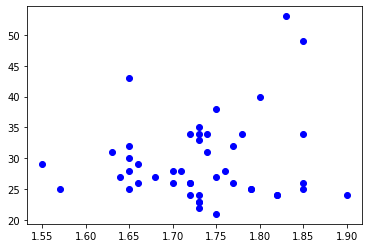

In [61]:
plt.scatter(x = trainset['Estatura'], y = trainset['Edad'], c = 'blue')
plt.show()

In [88]:
### parametros
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
## probabilidad
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):

        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='binary')
      
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon


In [77]:
mu, sigma = estimateGaussian(train)
p = multivariateGaussian(train,mu,sigma)

In [78]:
print(p)

[0.23431945 0.31009622 0.22670016 0.2208083  0.15095585 0.19969697
 0.14680711 0.0858851  0.07053945 0.1298267  0.19727557 0.1734548
 0.09782319 0.15281049 0.1734548  0.24569404 0.26016966 0.02912061
 0.18582358 0.28445693 0.26924266 0.0752     0.06213504 0.09782319
 0.1431563  0.25247859 0.0162055  0.28624323 0.24029438 0.16971073
 0.27630645 0.01364933 0.25481827 0.2765844  0.00051524 0.17421813
 0.22602604 0.16831363 0.19727557 0.01561357 0.27630645 0.11492684
 0.22529554 0.00246508 0.29927816 0.28606927]


In [89]:
p_cv = multivariateGaussian(validation[:, :-1],mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,validation[:, -1])
print(ep)
print(fscore)

0.0002832919790656053
1.0


In [85]:
p_test = multivariateGaussian(test[:, :-1],mu,sigma)

predictions = (p_test < ep)
test_f1_score = f1_score(validation[:, -1], predictions,average='binary') 


In [86]:
print(predictions)
print(test_f1_score)

[False False False False  True  True]
1.0
